In [1]:
# Importing necessary libraries for the analysis.
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import csv
import math

In [3]:
from utils import *
from autoencoder import Autoencoder
from diffusion_networks import *
from sampler import edm_sampler

In [55]:
# Defining the constants and configurations used throughout the notebook.
iterations = 2101000 # 101000
on_remote = False
data_path = Path(f'/nobackup/smhid20/users/sm_maran/dpr_data/simulations/QG_samples_SUBS_{iterations}.npy') if on_remote else Path(f'C:/Users/svart/Desktop/MEX/data/QG_samples_SUBS_{iterations}.npy')
k = 100
spinup = 1001
spacing = 10
p_train = 0.8
mean_data = 0.003394413273781538
std_data = 9.174626350402832

batch_size = 64

date = '2024-02-21'
autoencoder_model = 'ae-2ds-32f-1l-150e-L1-0wd-0.00001l1' #'ae-3ds-16f-2l-150e-L1-0wd-0.00001l1'# 

autoencoder_path = Path(f'/nobackup/smhid20/users/sm_maran/results/{date}/{autoencoder_model}/') if on_remote else Path(f'C:/Users/svart/Desktop/MEX/results/{date}/{autoencoder_model}/')

#ae-2ds-32f-1l-150e-L1-0wd-0.00001l1
mean_data_latent = -0.03832172974944115 # -0.6324582099914551
std_data_latent = 1.3086596727371216 # 5.280972003936768
std_residual_latent = 6.599302768707275# 5.724194526672363

#ae-3ds-16f-2l-150e-L1-0wd-0.00001l1
#mean_data_latent = -1.2714290618896484
#std_data_latent = 3.313279628753662

# Data Loading

In [56]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_dataset = QGSamplesDataset(data_path, 'train', p_train, k, spinup, spacing, iterations, mean_data, std_data, device)
val_dataset = QGSamplesDataset(data_path, 'val', p_train, k, spinup, spacing, iterations, mean_data, std_data, device)
test_dataset = QGSamplesDataset(data_path, 'test', p_train, k, spinup, spacing, iterations, mean_data, std_data, device)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Autoencoder

In [6]:
import json
# FILEPATH: /c:/Users/svart/Desktop/MEX/QG-Forecasting/Diffusion.ipynb
# Load the saved model
saved_model = torch.load(autoencoder_path / 'best_model.pth')

# Read parameters from JSON file
with open(autoencoder_path / 'config.json', 'r') as json_file:
    parameters = json.load(json_file)

# Extract the desired parameters
filters = parameters['filters']
latent_dim = parameters['latent_dim']
no_downsamples = parameters['no_downsamples']

# Create an instance of the ConvolutionalAutoencoder class
autoencoder = Autoencoder(filters= filters, no_latent_channels=latent_dim, no_downsamples=no_downsamples)

# Load the state_dict of the saved model into the conv_autoencoder
autoencoder.load_state_dict(saved_model)

autoencoder.to(device)
autoencoder.eval()

print("Autoencoder loaded successfully!")

Autoencoder loaded successfully!


In [54]:
def calculate_latent_mean_std():
    # Calculate mean and var
    # Initialize variables for mean and standard deviation
    mean_data_latent = 0.0
    std_data_latent = 0.0
    count = 0
    #autoencoder.to('cpu')
    # Iterate over the batches in train_loader
    autoencoder.eval()
    with torch.no_grad():
        for current, next in train_loader:
            # Get the input data from the batch
            latent = autoencoder.encoder(current)
            next_latent = autoencoder.encoder(next)
            
            inputs = next_latent# - latent

            count += inputs.size(0)

            # Calculate the sum of the input data
            mean_data_latent += torch.sum(inputs)
            std_data_latent += torch.sum(inputs ** 2)
            #print(mean_data_latent/count, std_data_latent/count, count)
            
        # Calculate the mean and standard deviation
        count = count * inputs[0].cpu().detach().numpy().size
        # TODO
        mean_data_latent /= count
        std_data_latent = torch.sqrt(std_data_latent / count - mean_data_latent ** 2)

        # Print the mean and standard deviation
        print("Mean:", mean_data_latent.item())
        print("Standard Deviation:", std_data_latent.item())

    return mean_data_latent, std_data_latent

calculate_latent_mean_std()
print(mean_data_latent, std_data_latent, std_residual_latent)

Mean: -0.6324582099914551
Standard Deviation: 5.280972003936768
-0.03832172974944115 1.3086596727371216 1.6244432926177979


# Diffusion

### Sampling

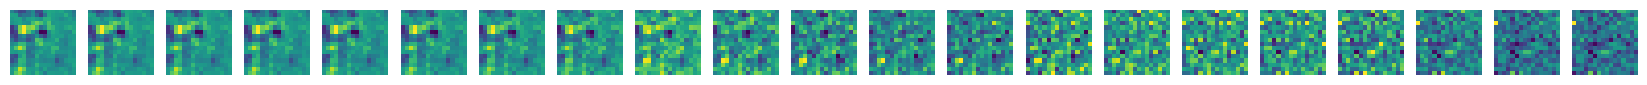

In [57]:
def sample_and_plot(net, class_labels = None, img_channels=1):
    sampler_fn = edm_sampler
    
    latents = torch.randn([1, img_channels, net.img_resolution, net.img_resolution], device=device)
    image, images  = sampler_fn(net, latents, class_labels, sigma_max=80, sigma_min=0.03, rho=7, num_steps=20, S_churn=2.5, S_min=0.75, S_max=70, S_noise=1.05)

    # TODO Fix such that you can plot smaller resolutions
    plt.figure(figsize=(images.shape[0], 1))
    plt.tight_layout()
    for i in range(images.shape[0]):
        plt.subplot(1, images.shape[0], i+1)
        plt.imshow(images[i,0, 0].cpu().detach().numpy())
        plt.axis('off')
    plt.show()
    
sample_and_plot(model, img_channels=2)

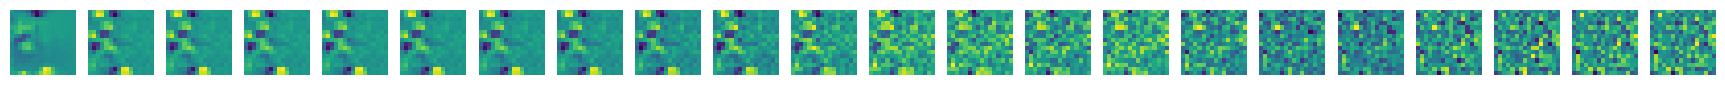

In [58]:
def sample_and_plot_with_truth(net, class_labels = None, truth = None):
    sampler_fn = edm_sampler
    
    latents = torch.randn([1, 1, net.img_resolution, net.img_resolution], device=device)
    image, images  = sampler_fn(net, latents, class_labels, sigma_max=80, sigma_min=0.03, rho=7, num_steps=20, S_churn=2.5, S_min=0.75, S_max=70, S_noise=1.05)

    if class_labels is not None:
        images = torch.cat([truth.unsqueeze(0), images], dim=0)
    
    plt.figure(figsize=(images.shape[0], 1))
    plt.tight_layout()
    for i in range(images.shape[0]):
        plt.subplot(1, images.shape[0], i+1)
        plt.imshow(images[i,0, 0].cpu().detach().numpy())
        plt.axis('off')
    plt.show()

for previous, current in train_loader:
    with torch.no_grad():
        current_latent = autoencoder.encoder(current)
        current_latent = (current_latent - mean_data_latent) / std_data_latent

        previous_latent = autoencoder.encoder(previous)
        previous_latent = (previous_latent - mean_data_latent) / std_data_latent

    current_latent = current_latent[0].unsqueeze(0)
    previous_latent = previous_latent[0].unsqueeze(0)
    break
sample_and_plot_with_truth(model, class_labels = previous_latent, truth = current_latent)

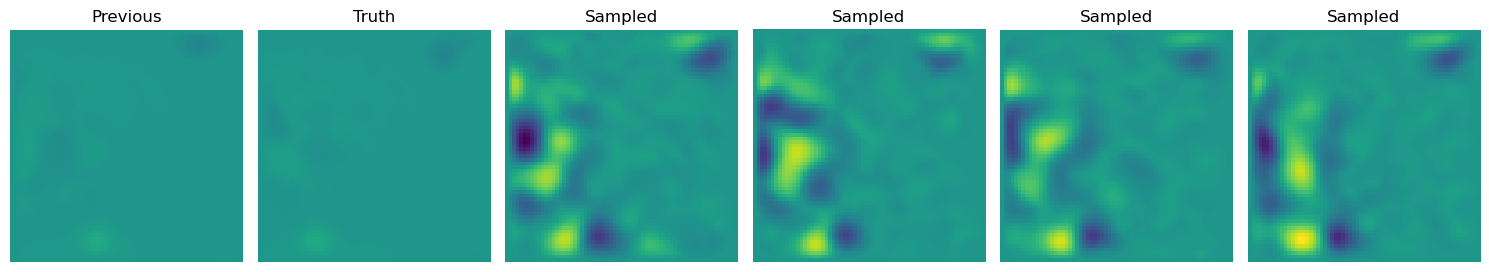

In [59]:
def plot_forecasts_from_residual(model, num_images=4):
    for previous, current in train_loader:
        with torch.no_grad():
            current_latent = autoencoder.encoder(current)
            previous_latent = autoencoder.encoder(previous)
            
            residual_latent = (current_latent - previous_latent) / std_residual_latent
        
        residual_latent = residual_latent[0].unsqueeze(0)
        previous_latent = previous_latent[0].unsqueeze(0)
        break

    img_channels = residual_latent.size(1)
    class_labels = previous_latent.repeat(num_images, 1, 1, 1)

    sampler_fn = edm_sampler
    latents = torch.randn([num_images, img_channels, model.img_resolution, model.img_resolution], device=device)
    residuals, _  = sampler_fn(model, latents, class_labels, sigma_max=80, sigma_min=0.03, rho=7, num_steps=20, S_churn=2.5, S_min=0.75, S_max=70, S_noise=1.05)

    predicted_latent = previous_latent + residuals * std_residual_latent

    predicted = autoencoder.decoder(predicted_latent.to(torch.float32)).cpu().detach().numpy()[:,0]
    previous = previous[0,0].cpu().detach().numpy()
    current = current[0,0].cpu().detach().numpy()

    vmin = min(predicted.min(), current.min(), previous.min())
    vmax = max(predicted.max(), current.max(), previous.max())

    fig, axes = plt.subplots(1, 2+num_images, figsize=(15, 5))

    axes[0].imshow(previous, vmin=vmin, vmax=vmax)
    axes[0].axis('off')
    axes[0].set_title('Previous')

    axes[1].imshow(current, vmin=vmin, vmax=vmax)
    axes[1].axis('off')
    axes[1].set_title('Truth')

    for i in range(num_images):
        axes[i+2].imshow(predicted[i], vmin=vmin, vmax=vmax)
        axes[i+2].axis('off')
        axes[i+2].set_title('Sampled')

    plt.tight_layout()
    plt.show()

plot_forecasts_from_residual(model)

### Training

In [61]:
forecasting = False

model = GCPrecond(filters=32, no_downsamples=2, img_channels=2 if forecasting else 1, img_resolution = 16)
print("Num params: ", sum(p.numel() for p in model.parameters()))

model.to(device)

optimizer = optim.Adam(model.parameters(), lr=0.0001)
loss_fn = GCLoss()

loss_values = []
val_loss_values = []
best_val_loss = float('inf')

# Setup for logging
log_file_path = 'training_log.csv'
with open(log_file_path, mode='w', newline='') as file:
    writer = csv.writer(file)
    # Write the header
    writer.writerow(['Epoch', 'Average Training Loss', 'Validation Loss'])

Num params:  924273


In [62]:
# Both Generation and Forecasting

import time
# Training loop
num_epochs = 30

for epoch in range(num_epochs):
    start_time = time.time()

    model.train()  # Set model to training mode
    total_train_loss = 0

    for previous, current in train_loader:        
        optimizer.zero_grad()

        with torch.no_grad():
            current_latent = autoencoder.encoder(current)
            previous_latent = None

            if forecasting:
                previous_latent = autoencoder.encoder(previous)
                target_latent = (current_latent - previous_latent) / std_residual_latent
            else:
                target_latent = (current_latent - mean_data_latent) / std_data_latent
            
        loss = loss_fn(model, target_latent, previous_latent)

        total_train_loss += loss.item()
        loss.backward()
        optimizer.step()
    
    avg_train_loss = total_train_loss / len(train_loader)
    
    train_time = time.time() - start_time
    start_time = time.time()

    # Validation phase
    model.eval()  # Set model to evaluation mode
    total_val_loss = 0
    with torch.no_grad():
        for previous, current in val_loader:
            current_latent = autoencoder.encoder(current)
            previous_latent = None

            if forecasting:
                previous_latent = autoencoder.encoder(previous)
                target_latent = (current_latent - previous_latent) / std_residual_latent
            else:
                target_latent = (current_latent - mean_data_latent) / std_data_latent
            
            loss = loss_fn(model, target_latent, previous_latent)
            
            total_val_loss += loss.item()
            
    avg_val_loss = total_val_loss / len(val_loader)

    # Checkpointing
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), 'best_model.pth')

    val_time = time.time() - start_time
    start_time = time.time()
    # scheduler.step()
        
    if forecasting:
        plot_forecasts_from_residual(model)
    else:
        sample_and_plot(model, img_channels=1)

    sample_time = time.time() - start_time
    
    # Log to CSV    
    loss_values.append([avg_train_loss])
    val_loss_values.append(avg_val_loss)  # Assuming val_loss_values list exists
    
    # Log to CSV
    with open(log_file_path, mode='a', newline='') as file:
        writer = csv.writer(file)
        writer.writerow([epoch+1, avg_train_loss, avg_val_loss])
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Average Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}')
    print(f'Training time: {train_time:.5f}s, Validation time: {val_time:.5f}s, Sample time: {sample_time:.5f}s')


# Plotting
plt.figure(figsize=(10, 6))
loss_plot = np.array(loss_values)
plt.plot(loss_plot[1:], label='Training Loss', color='blue')

plt.plot(val_loss_values[1:], label='Validation Loss', color='red')
plt.title('Loss as a Function of Epochs')
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
plt.grid(True)
plt.legend()
plt.show()

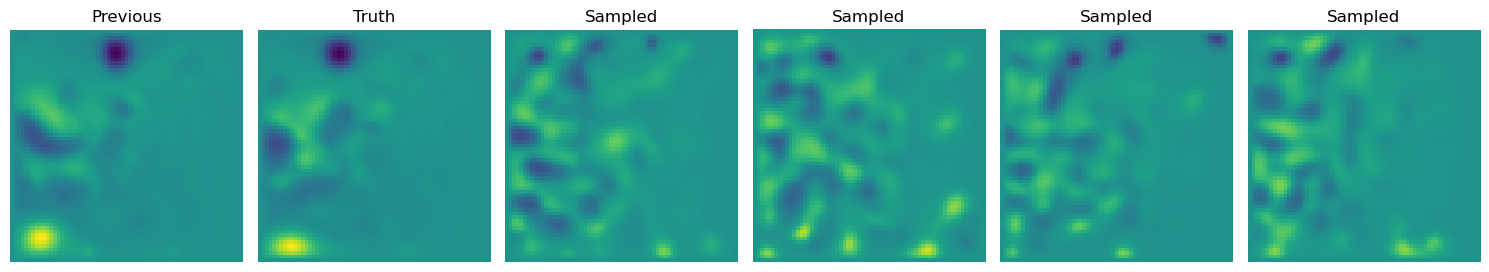

Epoch [1/30], Average Loss: 0.6234, Validation Loss: 0.6280
Training time: 109.97884s, Validation time: 12.33467s, Sample time: 0.52553s


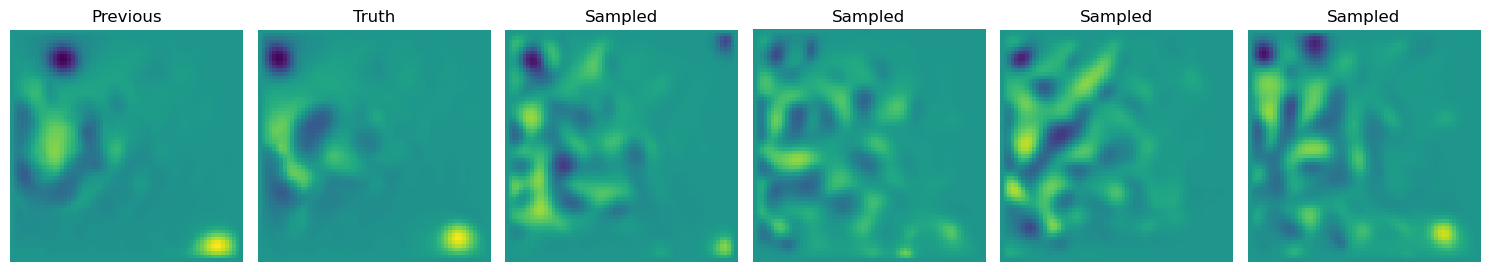

Epoch [2/30], Average Loss: 0.6218, Validation Loss: 0.6282
Training time: 118.40840s, Validation time: 13.15929s, Sample time: 0.39431s


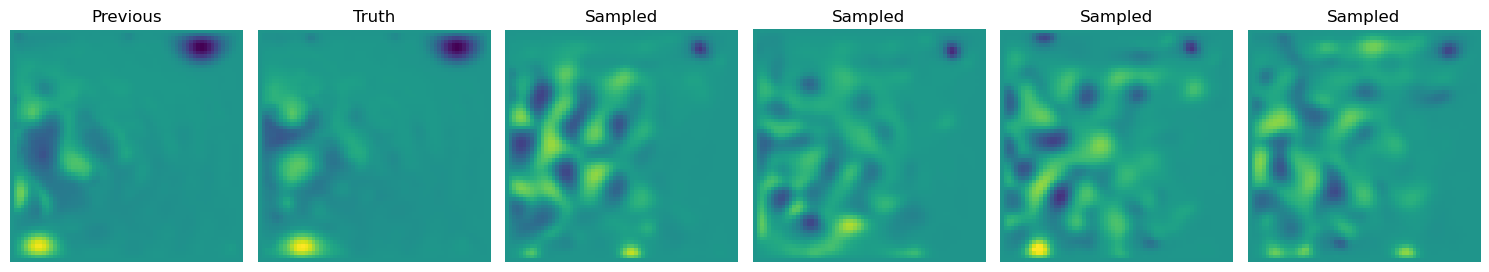

Epoch [3/30], Average Loss: 0.6220, Validation Loss: 0.6267
Training time: 120.95464s, Validation time: 13.60888s, Sample time: 0.57542s


KeyboardInterrupt: 

In [55]:
# Forecast whole solution

import time
# Training loop
num_epochs = 30

for epoch in range(num_epochs):
    start_time = time.time()

    model.train()  # Set model to training mode
    total_train_loss = 0

    for previous, current in train_loader:        
        optimizer.zero_grad()

        with torch.no_grad():
            current_latent = autoencoder.encoder(current)
            current_latent = (current_latent - mean_data_latent) / std_data_latent

            previous_latent = autoencoder.encoder(previous)
            previous_latent = (previous_latent - mean_data_latent) / std_data_latent
        
        #latent = img[:,:,:64,:64]
        
        loss = loss_fn(model, current_latent, previous_latent)

        #print(f'Loss: {loss.item(      
        total_train_loss += loss.item()
        loss.backward()
        optimizer.step()

    avg_train_loss = total_train_loss / len(train_loader)
    
    train_time = time.time() - start_time
    start_time = time.time()

    # Validation phase
    model.eval()  # Set model to evaluation mode
    total_val_loss = 0
    with torch.no_grad():
        for previous, current in val_loader:
            with torch.no_grad():
                current_latent = autoencoder.encoder(current)
                previous_latent = autoencoder.encoder(previous)
                current_latent = (current_latent - mean_data_latent) / std_data_latent
                previous_latent = (previous_latent - mean_data_latent) / std_data_latent
            
            #latent = img[:,:,:64,:64]
        
            loss = loss_fn(model, current_latent, previous_latent)

            total_val_loss += loss.item()
            
    avg_val_loss = total_val_loss / len(val_loader)

    # Checkpointing
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), 'best_model.pth')

    val_time = time.time() - start_time
    start_time = time.time()
    # scheduler.step()
        
    # Sample and plot image
    #sample_and_plot(model)
    plot_forecasts(model, )

    sample_time = time.time() - start_time
    
    # Log to CSV    
    loss_values.append([avg_train_loss])
    val_loss_values.append(avg_val_loss)  # Assuming val_loss_values list exists
    
    # Log to CSV
    with open(log_file_path, mode='a', newline='') as file:
        writer = csv.writer(file)
        writer.writerow([epoch+1, avg_train_loss, avg_val_loss])
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Average Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}')
    print(f'Training time: {train_time:.5f}s, Validation time: {val_time:.5f}s, Sample time: {sample_time:.5f}s')


# Plotting
plt.figure(figsize=(10, 6))
loss_plot = np.array(loss_values)
plt.plot(loss_plot[1:], label='Training Loss', color='blue')

plt.plot(val_loss_values[1:], label='Validation Loss', color='red')
plt.title('Loss as a Function of Epochs')
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
plt.grid(True)
plt.legend()
plt.show()

### Evaluate Forecasts

C:\Users\svart\AppData\Local\Temp\ipykernel_15096\1296318209.py:1: DeprecationWarning: Please use `uniform_filter1d` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import uniform_filter1d


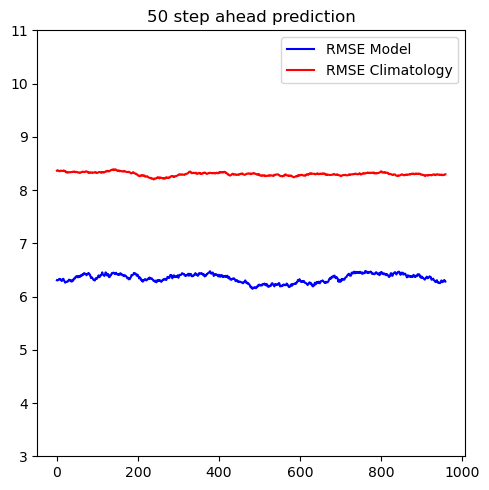

In [24]:
from scipy.ndimage.filters import uniform_filter1d
running_mean = 100

def generate_forecasts(model):
    model.eval()
    sampler_fn = edm_sampler

    num_images = 1000
    num_images -= num_images%64
    rmse_model_list = np.zeros(num_images)
    rmse_clim_list = np.zeros(num_images)

    count=0
    for previous, current in train_loader:
        with torch.no_grad():
            current_latent = autoencoder.encoder(current)
            previous_latent = autoencoder.encoder(previous)
            residual_latent = (current_latent - previous_latent) / std_residual_latent
            
            latents = torch.randn([residual_latent.size(0), residual_latent.size(1), model.img_resolution, model.img_resolution], device=device)
            class_labels = previous_latent

            predicted_residuals, _  = sampler_fn(model, latents, class_labels, sigma_max=80, sigma_min=0.03, rho=7, num_steps=20, S_churn=2.5, S_min=0.75, S_max=70, S_noise=1.05)
            predicted_latent = previous_latent + predicted_residuals * std_residual_latent
            
            predicted = autoencoder.decoder(predicted_latent.to(torch.float32))

            predicted_unscaled = predicted * std_data + mean_data
            current_unscaled = current * std_data + mean_data
            previous_unscaled = previous * std_data + mean_data

            climatology = current_unscaled.mean(dim=0)

            rmse_model = ((predicted_unscaled - current_unscaled)**2).mean(dim=(1,2,3)).sqrt().cpu().detach().numpy()
            rmse_clim = ((climatology - current_unscaled)**2).mean(dim=(1,2,3)).sqrt().cpu().detach().numpy()

            rmse_model_list[count:count+rmse_model.size] = rmse_model
            rmse_clim_list[count:count+rmse_model.size] = rmse_clim

            count += rmse_model.size
        if count >= num_images:
            break
        
    return rmse_model_list, rmse_clim_list

rmse_model, rmse_clim = generate_forecasts(model)

plt.figure(figsize=(5,5))
plt.title(f'{k} step ahead prediction')
plt.plot(uniform_filter1d(rmse_model, size=running_mean), label='RMSE Model', color='b')
plt.plot(uniform_filter1d(rmse_clim, size=running_mean), label='RMSE Climatology', color='r')
plt.ylim(3,11)
plt.legend()
plt.tight_layout()
plt.show()

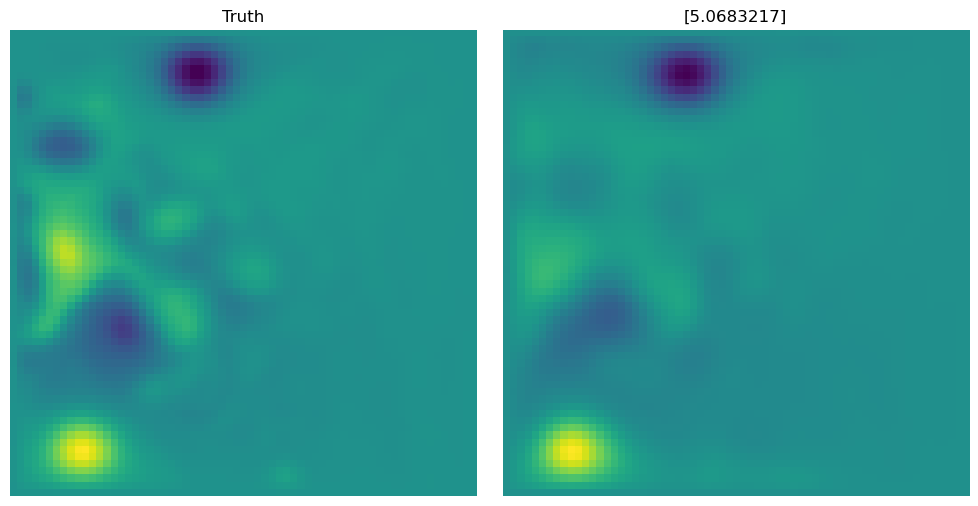

In [33]:
model.eval()
sampler_fn = edm_sampler

n_ens = 10
for previous, current in val_loader:
    with torch.no_grad():
        batch_size = current.size(0)

        current_latent = autoencoder.encoder(current)
        previous_latent = autoencoder.encoder(previous)
        residual_latent = (current_latent - previous_latent) / std_residual_latent
        
        for i in range(batch_size):
            latents = torch.randn([n_ens, residual_latent.size(1), model.img_resolution, model.img_resolution], device=device)
            class_labels = previous_latent[i].repeat(n_ens, 1, 1, 1)

            predicted_residuals, _  = sampler_fn(model, latents, class_labels, sigma_max=80, sigma_min=0.03, rho=7, num_steps=20, S_churn=2.5, S_min=0.75, S_max=70, S_noise=1.05)
            predicted_latent = class_labels + predicted_residuals * std_residual_latent
            
            predicted = autoencoder.decoder(predicted_latent.to(torch.float32))

            predicted_unscaled = predicted * std_data + mean_data
            current_unscaled = current[i] * std_data + mean_data
            break

    break

ensemble_mean = predicted_unscaled.mean(dim=0)
ensemble_rmse = ((ensemble_mean - current_unscaled)**2).mean(dim=(1,2)).sqrt()

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(current_unscaled[0].cpu().detach().numpy())
axes[0].set_title("Truth")
axes[0].axis('off')

axes[1].imshow(ensemble_mean[0].cpu().detach().numpy())
axes[1].set_title(ensemble_rmse.cpu().detach().numpy())
axes[1].axis('off')

plt.tight_layout()

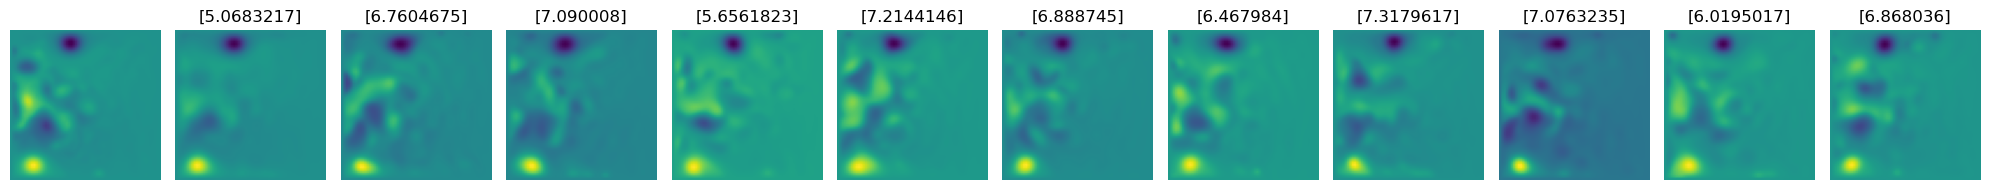

In [34]:
plt.figure(figsize=(20, 5))
plt.subplot(1, n_ens+1+1, 1)
plt.imshow(current_unscaled[0].cpu().detach().numpy())
plt.axis('off')
plt.tight_layout()

ensemble_mean = predicted_unscaled.mean(dim=0)
plt.subplot(1, n_ens+1+1, 2)
plt.imshow(ensemble_mean[0].cpu().detach().numpy())
plt.title(((ensemble_mean - current_unscaled)**2).mean(dim=(1,2)).sqrt().cpu().detach().numpy())
plt.axis('off')
plt.tight_layout()

for i in range(n_ens):
    plt.subplot(1, n_ens+1+1, i+1+1+1)
    plt.title(((predicted_unscaled[i] - current_unscaled)**2).mean(dim=(1,2)).sqrt().cpu().detach().numpy())
    plt.imshow(predicted_unscaled[i,0].cpu().detach().numpy())
    plt.axis('off')
    plt.tight_layout()

### Misc

In [113]:
# Fix a random image index
for data, _ in train_loader:
    random_image = data[0]
    break

# Get the latent representation of the random image
random_image = random_image.cpu().detach().numpy()

# Calculate the distances between the random image's latent representation and all other latent representations
real_distances = []
fake_distances = []

for data, _ in val_loader:
    data = data[0]
    real_distance = np.linalg.norm(random_image - data.cpu().detach().numpy())
    fake_distance = np.linalg.norm(images[0, 0].detach().numpy() - data.cpu().detach().numpy())

    real_distances.append(real_distance)
    fake_distances.append(fake_distance)


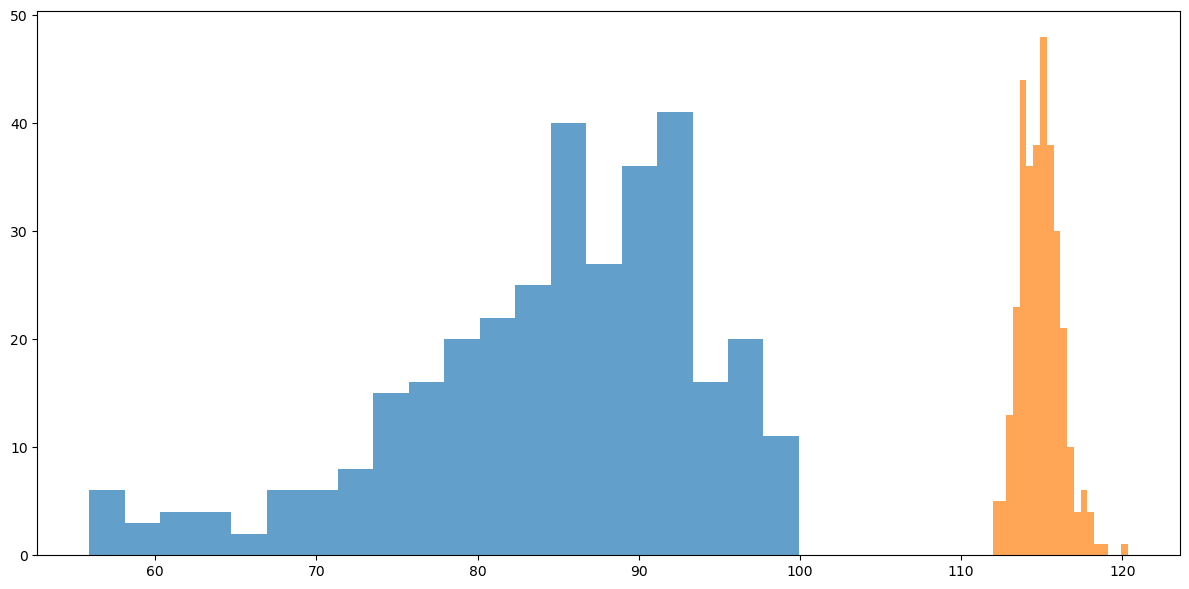

In [114]:
plt.figure(figsize=(12, 6))  # Adjust the figure size as desired

plt.hist(real_distances, bins=20, alpha=0.7, label='Real Images')
plt.hist(fake_distances, bins=20, alpha=0.7, label='Fake Images')

plt.tight_layout()  # Adjust the spacing between subplots
plt.show()

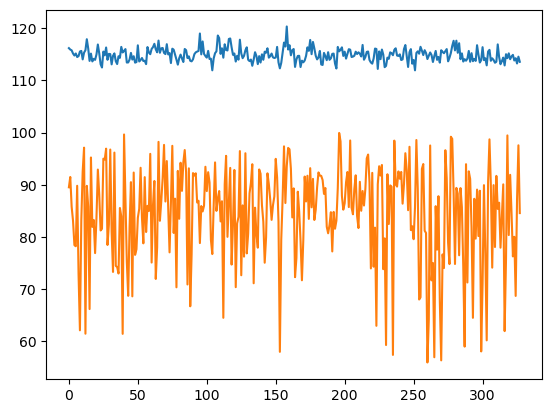

In [115]:
plt.plot(fake_distances)
plt.plot(real_distances)